# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
ls

collectSubmission.sh*  knn.ipynb*             softmax.ipynb*
cs231n/                README.md*             start_ipython_osx.sh*
features.ipynb*        requirements.txt*      svm.ipynb*
frameworkpython*       setup_googlecloud.sh*  two_layer_net.ipynb*


## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


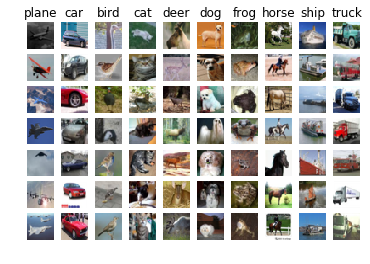

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


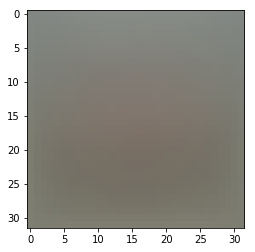

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.655125


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 3.805271 analytic: 3.805271, relative error: 3.417784e-12
numerical: -6.358013 analytic: -6.358013, relative error: 4.411477e-12
numerical: 15.334009 analytic: 15.334009, relative error: 1.292909e-11
numerical: -46.648094 analytic: -46.648094, relative error: 8.331968e-12
numerical: -5.494919 analytic: -5.494919, relative error: 6.996056e-11
numerical: -6.098096 analytic: -6.098096, relative error: 4.852782e-11
numerical: 7.037048 analytic: 7.037048, relative error: 7.238870e-11
numerical: 5.390566 analytic: 5.390566, relative error: 2.760577e-11
numerical: -11.907346 analytic: -11.907346, relative error: 2.526756e-11
numerical: -5.238194 analytic: -5.238194, relative error: 3.312700e-11
numerical: -8.004640 analytic: -8.004640, relative error: 1.042483e-11
numerical: -9.844499 analytic: -9.844499, relative error: 1.026261e-11
numerical: -5.798302 analytic: -5.798302, relative error: 2.446407e-11
numerical: 28.868089 analytic: 28.868089, relative error: 1.975043e-12
numerica

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *loss function is not differentiable in 0, so gradient check at 0 will fail. Changing the margin in such a way that shifts the loss function from zero will decrease the frequency of this happening*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.655125e+00 computed in 0.095195s
Vectorized loss: 8.655125e+00 computed in 0.004306s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.094795s
Vectorized loss and gradient: computed in 0.003713s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 782.974242
iteration 100 / 1500: loss 286.154961
iteration 200 / 1500: loss 108.011712
iteration 300 / 1500: loss 42.557886
iteration 400 / 1500: loss 19.220441
iteration 500 / 1500: loss 10.357386
iteration 600 / 1500: loss 7.303690
iteration 700 / 1500: loss 5.933953
iteration 800 / 1500: loss 5.425117
iteration 900 / 1500: loss 5.507459
iteration 1000 / 1500: loss 4.952980
iteration 1100 / 1500: loss 5.150882
iteration 1200 / 1500: loss 5.478181
iteration 1300 / 1500: loss 5.336585
iteration 1400 / 1500: loss 5.613367
That took 15.883665s


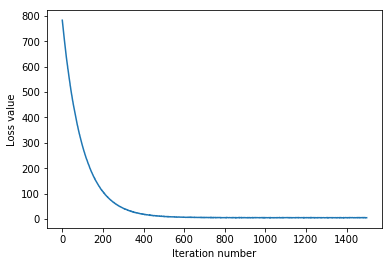

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.372429
validation accuracy: 0.383000


In [34]:
import random
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_lr = -1
best_r = -1
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.


################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################


for i in range(100):
    k = 10**random.uniform(-8, -6)
    j = 10**random.uniform(4, 5)
    svm = LinearSVM()
    tic = time.time()
    loss_hist = svm.train(X_train, y_train, learning_rate=k, reg=j,num_iters=1500, verbose=True)
    toc = time.time()
    print('That took %fs' % (toc - tic))
    y_train_pred = svm.predict(X_train)
    train_accur = np.mean(y_train == y_train_pred)   
    y_val_pred = svm.predict(X_val)
    val_accur = np.mean(y_val == y_val_pred)
    results[(k, j)]=(train_accur, val_accur)
      
    if val_accur>best_val:
        best_val = val_accur
        best_svm = svm
        best_lr = k
        best_r = j
        
            
           

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val) 

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 589.382888
iteration 100 / 1500: loss 471.228084
iteration 200 / 1500: loss 399.201817
iteration 300 / 1500: loss 347.807238
iteration 400 / 1500: loss 310.874852
iteration 500 / 1500: loss 283.673662
iteration 600 / 1500: loss 263.668802
iteration 700 / 1500: loss 247.659080
iteration 800 / 1500: loss 236.906208
iteration 900 / 1500: loss 227.544674
iteration 1000 / 1500: loss 220.147969
iteration 1100 / 1500: loss 214.797802
iteration 1200 / 1500: loss 209.883332
iteration 1300 / 1500: loss 205.300430
iteration 1400 / 1500: loss 201.979844
That took 13.944379s
iteration 0 / 1500: loss 432.435234
iteration 100 / 1500: loss 78.682468
iteration 200 / 1500: loss 22.974659
iteration 300 / 1500: loss 10.660802
iteration 400 / 1500: loss 6.975812
iteration 500 / 1500: loss 6.297918
iteration 600 / 1500: loss 5.874601
iteration 700 / 1500: loss 5.153249
iteration 800 / 1500: loss 5.174440
iteration 900 / 1500: loss 5.698613
iteration 1000 / 1500: loss 5.167878
iterat

iteration 200 / 1500: loss 219.043477
iteration 300 / 1500: loss 209.335394
iteration 400 / 1500: loss 202.598893
iteration 500 / 1500: loss 194.259108
iteration 600 / 1500: loss 190.517034
iteration 700 / 1500: loss 186.943876
iteration 800 / 1500: loss 184.074794
iteration 900 / 1500: loss 181.033768
iteration 1000 / 1500: loss 179.540910
iteration 1100 / 1500: loss 177.854084
iteration 1200 / 1500: loss 175.346798
iteration 1300 / 1500: loss 175.938887
iteration 1400 / 1500: loss 175.768289
That took 13.846388s
iteration 0 / 1500: loss 648.388817
iteration 100 / 1500: loss 225.601123
iteration 200 / 1500: loss 98.047571
iteration 300 / 1500: loss 51.476115
iteration 400 / 1500: loss 31.116596
iteration 500 / 1500: loss 20.934415
iteration 600 / 1500: loss 16.492877
iteration 700 / 1500: loss 12.698194
iteration 800 / 1500: loss 12.077738
iteration 900 / 1500: loss 9.564715
iteration 1000 / 1500: loss 9.171641
iteration 1100 / 1500: loss 8.744663
iteration 1200 / 1500: loss 8.085473


iteration 500 / 1500: loss 5.215739
iteration 600 / 1500: loss 5.261913
iteration 700 / 1500: loss 5.705707
iteration 800 / 1500: loss 5.521153
iteration 900 / 1500: loss 5.128379
iteration 1000 / 1500: loss 4.669415
iteration 1100 / 1500: loss 4.637881
iteration 1200 / 1500: loss 4.704631
iteration 1300 / 1500: loss 4.920972
iteration 1400 / 1500: loss 4.783967
That took 13.875738s
iteration 0 / 1500: loss 317.808082
iteration 100 / 1500: loss 252.449118
iteration 200 / 1500: loss 213.827494
iteration 300 / 1500: loss 188.735231
iteration 400 / 1500: loss 167.346257
iteration 500 / 1500: loss 153.435755
iteration 600 / 1500: loss 141.767938
iteration 700 / 1500: loss 134.312632
iteration 800 / 1500: loss 129.434149
iteration 900 / 1500: loss 122.638615
iteration 1000 / 1500: loss 119.481972
iteration 1100 / 1500: loss 115.812677
iteration 1200 / 1500: loss 113.232494
iteration 1300 / 1500: loss 111.614452
iteration 1400 / 1500: loss 110.254940
That took 13.821572s
iteration 0 / 1500: 

iteration 700 / 1500: loss 5.662126
iteration 800 / 1500: loss 5.356728
iteration 900 / 1500: loss 4.841371
iteration 1000 / 1500: loss 4.710405
iteration 1100 / 1500: loss 5.157167
iteration 1200 / 1500: loss 5.335330
iteration 1300 / 1500: loss 5.054157
iteration 1400 / 1500: loss 4.900632
That took 13.688999s
iteration 0 / 1500: loss 1364.771860
iteration 100 / 1500: loss 5.544168
iteration 200 / 1500: loss 6.671071
iteration 300 / 1500: loss 6.104154
iteration 400 / 1500: loss 6.142546
iteration 500 / 1500: loss 4.877023
iteration 600 / 1500: loss 5.597871
iteration 700 / 1500: loss 5.339923
iteration 800 / 1500: loss 5.662839
iteration 900 / 1500: loss 5.624552
iteration 1000 / 1500: loss 5.598554
iteration 1100 / 1500: loss 5.230107
iteration 1200 / 1500: loss 5.518766
iteration 1300 / 1500: loss 5.630912
iteration 1400 / 1500: loss 5.968409
That took 13.771360s
iteration 0 / 1500: loss 244.876893
iteration 100 / 1500: loss 223.931502
iteration 200 / 1500: loss 216.022928
iterati

iteration 900 / 1500: loss 4.464677
iteration 1000 / 1500: loss 5.064726
iteration 1100 / 1500: loss 4.646412
iteration 1200 / 1500: loss 5.121744
iteration 1300 / 1500: loss 5.130365
iteration 1400 / 1500: loss 4.489158
That took 14.238978s
iteration 0 / 1500: loss 1142.215793
iteration 100 / 1500: loss 77.490881
iteration 200 / 1500: loss 13.642413
iteration 300 / 1500: loss 6.823409
iteration 400 / 1500: loss 6.251522
iteration 500 / 1500: loss 5.223112
iteration 600 / 1500: loss 5.437379
iteration 700 / 1500: loss 5.167090
iteration 800 / 1500: loss 5.749182
iteration 900 / 1500: loss 5.300780
iteration 1000 / 1500: loss 4.917953
iteration 1100 / 1500: loss 5.428947
iteration 1200 / 1500: loss 5.794917
iteration 1300 / 1500: loss 5.128145
iteration 1400 / 1500: loss 5.212348
That took 13.774169s
iteration 0 / 1500: loss 676.046846
iteration 100 / 1500: loss 567.405093
iteration 200 / 1500: loss 492.820522
iteration 300 / 1500: loss 440.790787
iteration 400 / 1500: loss 400.563019
i

iteration 1200 / 1500: loss 29.489062
iteration 1300 / 1500: loss 28.466311
iteration 1400 / 1500: loss 27.228462
That took 13.820382s
iteration 0 / 1500: loss 871.144312
iteration 100 / 1500: loss 259.381132
iteration 200 / 1500: loss 99.663149
iteration 300 / 1500: loss 46.823642
iteration 400 / 1500: loss 26.358244
iteration 500 / 1500: loss 17.566097
iteration 600 / 1500: loss 12.882773
iteration 700 / 1500: loss 11.406512
iteration 800 / 1500: loss 8.845024
iteration 900 / 1500: loss 8.587691
iteration 1000 / 1500: loss 8.261145
iteration 1100 / 1500: loss 7.397797
iteration 1200 / 1500: loss 7.329686
iteration 1300 / 1500: loss 7.306328
iteration 1400 / 1500: loss 6.999529
That took 13.906289s
iteration 0 / 1500: loss 209.480482
iteration 100 / 1500: loss 194.874736
iteration 200 / 1500: loss 185.386470
iteration 300 / 1500: loss 178.520562
iteration 400 / 1500: loss 174.446174
iteration 500 / 1500: loss 169.113513
iteration 600 / 1500: loss 167.494029
iteration 700 / 1500: loss 

iteration 1300 / 1500: loss 83.536451
iteration 1400 / 1500: loss 80.952077
That took 13.738421s
iteration 0 / 1500: loss 609.976291
iteration 100 / 1500: loss 565.547795
iteration 200 / 1500: loss 535.121713
iteration 300 / 1500: loss 507.479205
iteration 400 / 1500: loss 491.908030
iteration 500 / 1500: loss 474.151517
iteration 600 / 1500: loss 460.617261
iteration 700 / 1500: loss 450.737306
iteration 800 / 1500: loss 442.382679
iteration 900 / 1500: loss 436.859571
iteration 1000 / 1500: loss 431.399149
iteration 1100 / 1500: loss 427.103350
iteration 1200 / 1500: loss 423.713716
iteration 1300 / 1500: loss 423.365130
iteration 1400 / 1500: loss 418.877268
That took 14.008687s
iteration 0 / 1500: loss 219.388847
iteration 100 / 1500: loss 201.641177
iteration 200 / 1500: loss 193.232586
iteration 300 / 1500: loss 186.649939
iteration 400 / 1500: loss 181.355940
iteration 500 / 1500: loss 177.070812
iteration 600 / 1500: loss 172.563296
iteration 700 / 1500: loss 170.385876
iterati

iteration 1300 / 1500: loss 51.051273
iteration 1400 / 1500: loss 49.520418
That took 13.778671s
iteration 0 / 1500: loss 261.955264
iteration 100 / 1500: loss 206.677060
iteration 200 / 1500: loss 175.059804
iteration 300 / 1500: loss 151.884697
iteration 400 / 1500: loss 136.445375
iteration 500 / 1500: loss 124.640071
iteration 600 / 1500: loss 116.615394
iteration 700 / 1500: loss 108.621530
iteration 800 / 1500: loss 104.018552
iteration 900 / 1500: loss 100.030298
iteration 1000 / 1500: loss 96.327689
iteration 1100 / 1500: loss 93.968874
iteration 1200 / 1500: loss 91.509654
iteration 1300 / 1500: loss 89.795339
iteration 1400 / 1500: loss 89.187224
That took 13.817593s
lr 1.019104e-08 reg 3.844408e+04 train accuracy: 0.186469 val accuracy: 0.190000
lr 1.141680e-08 reg 1.947401e+04 train accuracy: 0.188143 val accuracy: 0.206000
lr 1.202299e-08 reg 1.545206e+04 train accuracy: 0.186163 val accuracy: 0.199000
lr 1.442170e-08 reg 3.710770e+04 train accuracy: 0.188959 val accuracy:

4.372115013896279e-07 17980.799984101122


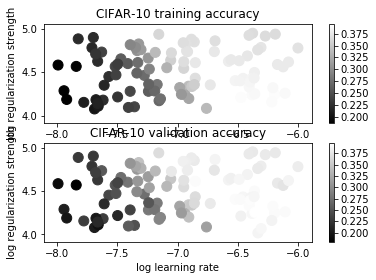

In [38]:
print(best_lr, best_r)

#4.372115013896279e-07 17980.799984101122 best lr and best r with decay best validation accuracy achieved during cross-validation: 0.398000
#linear SVM on raw pixels final test set accuracy: 0.376000
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [46]:
# Evaluate the best svm on test set
#одинаково что с заатуханием что без
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.376000


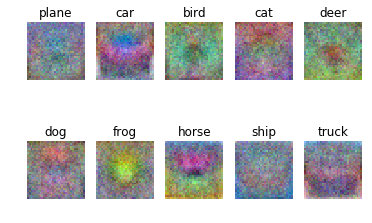

In [45]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *они выглядят как под кислотой. Они выглядят как размытые общие очертания рисунка,когда только проснёшься и открываешь глаза. Очертания неясные. Это связано с тем, что SVM проводит линии, разбивающие точки на классы, основываясь на сходстве пикселей, игнорируя края*